# Bayesian Optimization

## Motivation

Optimization is already introduced in the context of machine learning as a way to obtain the parameters of a model that minimize the approximation error or a similar metric. In general, optimization is applied to various kinds of problems. For engineers, product and process design optimization, trajectory control. parameter identification and model validation are some of the most important use cases for deploying optimization algorithms. As such, an efficient solution of optimization problems is important and we present a probabilistic strategy in the following.

### Exploration vs. Exploitation
Various optimization algorithms exist with different advantages and disadvantages. Gradient-based methods often require less iterations compared to e.g. population based methods but they require the gradient and possibly higher order derivatives. Moreover, they may get stuck at local optima or saddle points. As such, multiple starts may be required, which increases the number of iterations.

In contrast, population-based methods are often good at *exploration*, i.e. searching the global optimization space for candidate optima. In return, these methods often require more function evaluations compared to gradient-based methods. Moreover, their convergence rate to the exact optimum is often slower compared to the gradient-based methods. In other words, gradient-free methods are often better at finding the *neighbourhood* of the optimum with increasing accuracy over iterations but gradient-based methods are often more efficient at finding the exact optimum given a start point in the *convex* neighbourhood, which will be called *exploitation* from here on. Note that, these statements may not hold for all functions and all algorithms in these categories but they serve as an example of exploration and exploitation trade-off in the context of optimization. This trade-off has a large influence on the choice of the optimization algorithm.

### Sample efficiency

In practical applications, other properties such as the *sample efficiency* may be more important. Consider the single objective optimization problem [as defined before](https://probabilistic-ml.github.io/lecture-notes/01_fund/04_opt.html#a-formal-definition)

\begin{equation}
\mathrm{arg}\, \min_x f(x)
\end{equation}

Given that two algorithms can find the optimum $x^* \in \mathbb{R}^d$, the one that requires a smaller number of function evaluations $n \in \mathbb{N}$ is considered more sample efficient. However, some algorithms may result in different solutions $x^*_1, x^*_2 \in \mathbb{R}^d$ and one or both of of them may be different than the true optimum, for example $f(x^*) < f(x^*_1) < f(x^*_2)$. In this case, further domain knowledge is required to assess the sample efficiency, so that the cost of an evaluation becomes comparable to the cost of a function evaluation. 

Since the function evaluation may represent anything from expensive physical experiments to long running computations, the sample efficiency has a direct influence on the total costs of designing a product or a process. Remember that analysis of such expensive functions are one of the motivations behind applying machine learning to obtain surrogate functions that approximate these. Thus, a much pragmatic definition of the sample efficiency is adopted here. Given a relatively low budget of function evaluations, the algorithm that achieves the best solution is assumed to be the most sample efficient. 

### Surrogate-based strategies

Using a surrogate model $\tilde{f}(x) \approx f(x)$ for the optimization such as a Gaussian process may already decrease the number of required samples. Since the evaluation of this surrogate model is assumed to be much cheaper than the original function, greedy optimization algorithms can be deployed to solve the following problem

\begin{equation}
\mathrm{arg} \min_x \tilde{f}(x)
\end{equation}

in the hope that $\mathrm{arg}\min_x \tilde{f}(x) \approx \mathrm{arg}\min_x f(x)$, which may not hold if the surrogate model is inaccurate. In this case, improving the accuracy of the model is required, e.g. by increasing the amount of data and thus the number of function evaluations.

### Adaptive sampling
Adaptive sampling strategies are proposed to increase the sample efficiency of the surrogate-based solutions, where a model is initialized with a small portion of the total budget. At each iteration, new data points are queried and the model is retrained to refine the model accuracy in regions, that are relevant for the solution of the optimization problem. 

Bayesian optimization {cite}```Mockus1994,Jones2008``` decribes a category of adaptive sampling algorithms, that use a probabilistic surrogate model and solve an *auxiliary* problem by using the so-called *acquisition functions* $a(\cdot)$. Through the use of model uncertainty, they seek to improve the sample-efficiency of surrogate based solutions. 

Consider a Gaussian process $\tilde{f} \sim \mathcal{GP}$ as the surrogate model. As mentioned [before](https://probabilistic-ml.github.io/lecture-notes/02_probML/02_GPforML/02_GP.html), each prediction $\tilde{f}(x) = Y \sim \mathcal{N}(\mu_Y(x), \sigma_Y(x))$ represents a normal distribution. Thus, the surrogate-based problem from before could be rewritten as

\begin{equation}
\mathrm{arg}\min_x \mu_Y(x)
\end{equation}

From a Bayesian optimization perspective, this acquisition function $a(x)=\mu_Y(x)$ is called the mean acquisition. More generally, some of the most popular acquisition functions are in form $a: \mathbb{R}^2 \rightarrow \mathbb{R}$ and the Bayesian optimization problem can be denoted as 

\begin{equation}
\mathrm{arg}\min_x a(\mu_Y(x), \sigma_Y(x))
\end{equation}

Here, three well-known acquisition functions are introduced but there are a number of alternatives and constructing useful acquisition functions is an actively researched topic (see [black-box optimization challenge](https://bbochallenge.com)). An overview of some functions can be found [here](https://arxiv.org/pdf/1807.02811.pdf).



## Acquisition functions for Bayesian optimization

### Lower confidence bound (LCB)

Using the mean acquisition function may lead to model not exploring unseen regions. Consider the following one dimensional example.

\begin{equation}
\mathrm{arg}\min_x \sin(x) + \sin(\frac{10}{3}x)
\end{equation}

evaluated in $x \in [2.7, 7.5]$.

In [1]:
# Import libraries
import numpy as np
np.random.seed(42)
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, ConstantKernel, WhiteKernel
import matplotlib.pyplot as plt
plt.rcParams.update({
    "text.usetex": True,
    "font.size": 20})

In [2]:
# Define the objective function

def obj(x):
    return np.sin(x) + np.sin(10 * x / 3)

lower_bound = 2.7
upper_bound = 7.5



For the surrogate based solution, let us fit a $\mathcal{GP}$ and visualize the mean acquisition

In [3]:
# Fit a GP
x_train = np.random.rand(6).reshape((-1, 1))
x_train = x_train * (upper_bound - lower_bound) + lower_bound
y_train = obj(x_train)
kernel = ConstantKernel() * RBF(length_scale=1.0, length_scale_bounds=(1e-10, 1e6)) 

model = GaussianProcessRegressor(kernel, n_restarts_optimizer=10)

_ = model.fit(x_train, y_train)


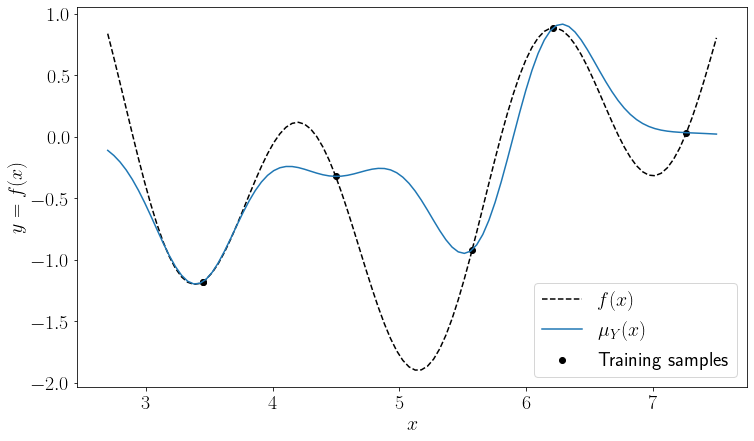

In [4]:
# Visualize mean acquisition
x_grid = np.linspace(lower_bound, upper_bound, 100)
y_true = obj(x_grid)
y_pred_mu, y_pred_std = model.predict(x_grid.reshape((-1, 1)), return_std=True)
y_pred_mu = y_pred_mu.ravel()

fig, ax = plt.subplots(figsize=(12, 7))

ax.plot(x_grid, y_true, "--k", label="$f(x)$")
ax.plot(x_grid, y_pred_mu, label="$\mu_Y(x)$")
plt.scatter(x_train.ravel(), y_train.ravel(), label="Training samples", color="k")
ax.set_xlabel("$x$")
ax.set_ylabel("$y=f(x)$")
_ = ax.legend()


It can be seen that the minimum of the mean prediction is very close to an existing sample and corresponds to a local minimum of the original function. As such, using mean acquisition would result in a solution, where the exploitation is weighted heavily. Instead of exploring unknown regions, it would prefer looking for improvements near the already known small values. For increasing exploration, lower confidence bound (LCB) can be used instead as an acquisition function

\begin{equation}
a(\mu_Y(x), \sigma_Y(x)) = \mu_Y(x) - \alpha * \sigma_Y(x)
\end{equation}

where $\alpha \in \mathbb{R}$ is a positive factor. A larger $\alpha$ would weight the exploration more. Let us use $\alpha=1.96$, which would be the z-score of the double sided $95\%$ confidence bounds of a normal distribution

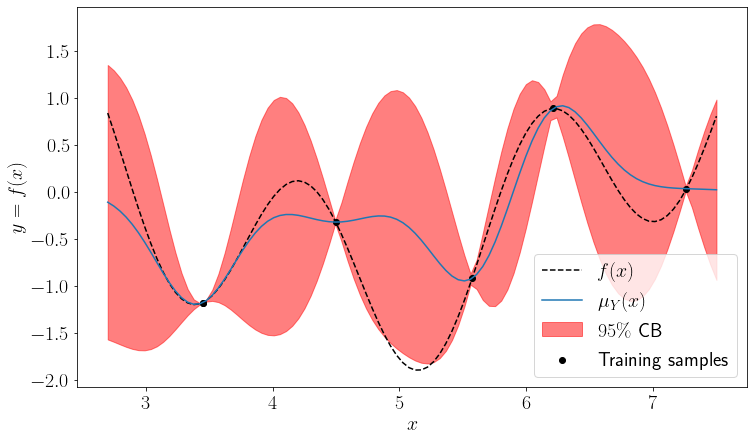

In [5]:
y_lcb = y_pred_mu - 1.96 * y_pred_std 
y_ucb = y_pred_mu + 1.96 * y_pred_std

fig, ax = plt.subplots(figsize=(12, 7))
ax.fill_between(x_grid, y_lcb, y_ucb, alpha=0.5, color="red", label="$95\%$ CB")
ax.plot(x_grid, y_true, "--k", label="$f(x)$")
ax.plot(x_grid, y_pred_mu, label="$\mu_Y(x)$")
ax.scatter(x_train.ravel(), y_train.ravel(), label="Training samples", color="k")
ax.set_xlabel("$x$")
ax.set_ylabel("$y=f(x)$")
_ = ax.legend()

It can be seen that the LCB function would prefer the next sample to be near the global optimum. Thus, the exploration behaviour is improved compared to the mean acquisition. Note that, thus acquisition is sometimes also called the optimistic or upper confidence bound (UCB) acquisition. The latter makes sense in the context of maximization problems.

There are two important observations about the LCB, that guarantee convergence given that the used optimization method is able to solve the original problem. In the noise free case, as the number of samples $n$ goes to infinity, the approximation error 
\begin{equation}
\lim_{n\rightarrow\infty} ||\mu_Y(x) - f(x)|| = 0
\end{equation}
and the model variance $\sigma^2_Y(x)$
\begin{equation}
\lim_{n\rightarrow\infty} \sigma^2_Y(x) = 0
\end{equation}
given infinite computation power and a noise free $f(\cdot)$. The first condition is a result of the universal approximation theorem as derived [here](https://jmlr.csail.mit.edu/papers/volume7/micchelli06a/micchelli06a.pdf) for some of the kernels discussed [before](https://probabilistic-ml.github.io/lecture-notes/02_probML/02_GPforML/04_kernels.html). The second one is true due to the definition of the prediction variance, which is zero for known points $x$ (see [noise-free equations](https://probabilistic-ml.github.io/lecture-notes/02_probML/02_GPforML/03_GPregression.html) and replace $X^*$ with $X$ for a proof). 

Thus, as the number of samples goes to infinity, the acquisition function $a(\cdot)$ converges to the true function $f(\cdot)$. This is rather a theoretical result to justify using LCB. However, the more important aspect of LCB and any other optimization algorithm is the rate of convergence. LCB seeks to increase this rate by discounting the objective value by some multiple of the prediction standard deviation $\sigma_Y(x)$, thus encouraging more exploration. For unscaled data, choosing $\alpha$ may not be trivial. Moreover, although $\sigma_Y(x)$ is expected to decrease through inclusion of new samples, the contribution of the model uncertainty to the acquisition function and thus the trade-off between exploration and exploitation remains constant.

### Probability of Improvement

The probabilistic nature of our surrogate model allows using probabilistic reasoning to choose an acquisition function. Let us define $y^* = f(x_k)$ to be the best sample observed so far, where $x_k \in \mathbb{R}^d$ is the input coordinates of the $k$-th sample point. We can define improvement $I$ of the current iteration as

\begin{equation}
I(x) = y^* - Y(x)
\end{equation}

where $Y(x) \sim \mathcal{N}(\mu_Y(x), \sigma_Y(x))$ is the distribution predicted by our $\mathcal{GP}$. Since $y^*$ is a constant, $I(x) \sim \mathcal{N}(y^* -\mu_Y(x), \sigma_Y(x))$ is also a Gaussian variable. Thus, probability of improvement defines the acquisition function as follows

\begin{equation}
a(\mu_Y(x), \sigma_Y(x)) = P(I(x)) = P(Y(x) \leq y^*) = \Phi(\frac{y^* -\mu_Y(x)}{\sigma_Y(x)})
\end{equation}

where $\Phi(\cdot)$ is the standard normal cumulative density function (CDF). There are some differences compared to the previous acquisition functions. Firstly, we want to maximize the probability of improvement and the surrogate problem can be denoted as 
\begin{equation}
\mathrm{arg}\max_x a(\mu_Y(x), \sigma_Y(x))
\end{equation}

Moreover, probability of improvement weights exploitation even more than the mean acquisition function, since not only we want to minimize $\mu_Y(x)$ but also $\sigma_Y(x)$ to maximize $P(I(x))$ as $\Phi$ is a monotonically increasing function. Let us visualize it for the 1-D example to see this clearly.

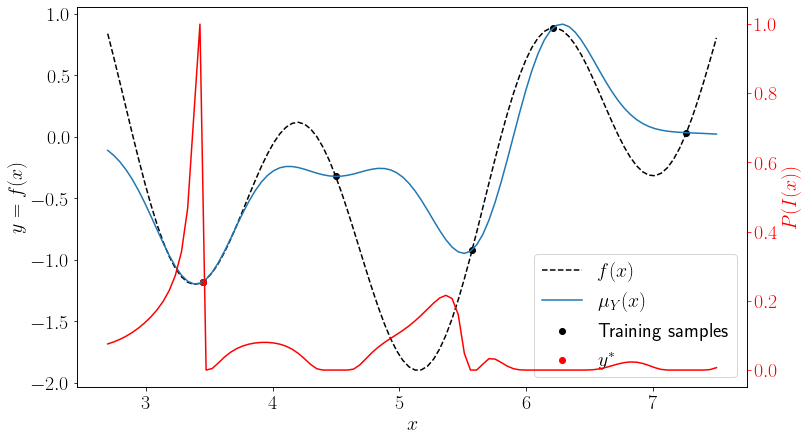

In [6]:
star = np.argmin(y_train)
x_star = x_train[star]
y_star = y_train[star]
y_pi = norm().cdf((y_star - y_pred_mu)/ y_pred_std)

fig, ax = plt.subplots(figsize=(12, 7))

ax.plot(x_grid, y_true, "--k", label="$f(x)$")
ax.plot(x_grid, y_pred_mu, label="$\mu_Y(x)$")
ax.scatter(x_train.ravel(), y_train.ravel(), label="Training samples", color="k")
ax.scatter(x_star, y_star, label="$y^*$", color="r")
ax2 = ax.twinx()
ax2.plot(x_grid, y_pi, color="r")
ax.set_xlabel("$x$")
ax.set_ylabel("$y=f(x)$")
ax2.set_ylabel("$P(I(x))$")
ax2.yaxis.label.set_color("r")
ax2.tick_params(axis='y', colors='red')
_ = ax.legend()


It can be seen that using $P(I(x))$ would result in a solution very close to a known sample, similar to the mean acquisition function. As such, $P(I(x))$ is often not the best choice for low sample settings, where exploration is often more important. However, it can improve the exploitation if used later on or in combination with other acquisition functions (see for example [hedge acquisition](https://arxiv.org/pdf/1009.5419.pdf)).

### Expected improvement
Another improvement based acquisition function, which is quite popular is the expected improvement. Notice that the expectation of the improvement variable $I(x) \sim \mathcal{N}$ defined before would be

\begin{equation}
\mathrm{E}[I(x)] = y^* - \mu_Y(x)
\end{equation}

which would be aquivalent to using the mean acquisition function. However, it becomes more useful, if we disregard the negative improvement values. Thus, let us redefine the improvement as

\begin{equation}
I(x) = max(0, y^* - Y)
\end{equation}

Due to the max operation, $I(x)$ is no longer a Gaussian variable. However, using the integral form, we can derive the expectation

\begin{equation}
E[I(x)] = \int_{-\infty}^{\infty} s f_I(s) ds
\end{equation}

where $f_I: \mathbb{R}\rightarrow\mathbb{R}$ is the probability density function (PDF) of $I(x)$. For a concise notation, let us define $\mu=\mu_Y(x)$ and $\sigma=\sigma_Y(x)$. Using the reparametrization trick, we can rewrite $Y$ as 

\begin{equation}
Y = \mu + \sigma U
\end{equation}

where $U \sim \mathcal{N}(0, 1)$ is a standard normal variable. Notice that 

\begin{equation}
f_I(s) = \left\{ 
  \begin{array}{ c l }
    \phi(\frac{s}{\sigma}) & \quad \textrm{if } s \geq 0 \\
    0                 & \quad \textrm{otherwise}
  \end{array}
\right.
\end{equation}

per definition, where $\phi(\cdot)$ denotes the standard normal PDF. For ease of notation, let us define a variable $z=\frac{y^* -\mu}{\sigma}$. Using these equations, we can rewrite the integral as follows and solve it

\begin{align}
E[I(x)] =& \int_{-\infty}^{z} (y^* - \mu - \sigma u) \phi(u) du \\
    =& (y^* - \mu)\Phi(z) - \sigma \int_{-\infty}^{z} u\phi(u) du \\
    =& (y^* - \mu)\Phi(z) - \frac{\sigma}{2\pi} \int_{-\infty}^{z} u e^{\frac{-u^2}{2}} du \\
    =& (y^* - \mu)\Phi(z) + \frac{\sigma}{2\pi} e^{\frac{-z^2}{2}} \\
 a(\mu, \sigma) = E[I(x)] =& (y^* - \mu)\Phi(z) + \sigma \phi(z) \\
\end{align}

Similar to the probability of improvement, $E[I(x)]$ is to be maximized as an acquisition function. The closed form solution of the expectation operation above consists of two terms. The first term is a scaled version of the probability of improvement and encourages exploitation. The second term increases the expected improvement as the model uncertainty $\sigma$ increases. Thus, expected improvement seeks to achieve a trade-off between exploration and exploitation using the standard normal PDF ($\phi$) and CDF ($\Phi$) values. Let us plot it for the 1-D example.

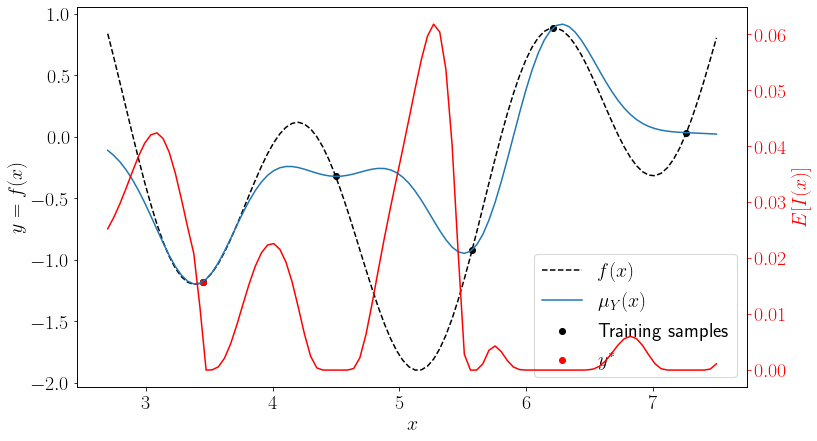

In [7]:
z = (y_star - y_pred_mu)/ y_pred_std
y_ei = (y_star - y_pred_mu) * norm().cdf(z) + y_pred_std * norm().pdf(z)
y_ei[y_pred_std <=0] = 0 # Not part of the derivation above but useful in practice to avoid repeated samples

fig, ax = plt.subplots(figsize=(12, 7))

ax.plot(x_grid, y_true, "--k", label="$f(x)$")
ax.plot(x_grid, y_pred_mu, label="$\mu_Y(x)$")
ax.scatter(x_train.ravel(), y_train.ravel(), label="Training samples", color="k")
ax.scatter(x_star, y_star, label="$y^*$", color="r")
ax2 = ax.twinx()
ax2.plot(x_grid, y_ei, color="r")
ax.set_xlabel("$x$")
ax.set_ylabel("$y=f(x)$")
ax2.set_ylabel("$E[I(x)]$")
ax2.yaxis.label.set_color("r")
ax2.tick_params(axis='y', colors='red')
_ = ax.legend()

Similar to the LCB, using $E[I(x)]$ would yield a query near the global optimum of the true function at this step.  

### Probability of Feasibility

So far, we have only talked about unconstrained problems. However, many problems in engineering applications have some constraints. Thus, accounting for the model uncertainty when evaluating the constraints can be useful due to same motivations as before. Consider the following constrained optimization problem.

\begin{align}
\mathrm{arg}\min_x \, & f(x)\\
\mathrm{s.t.} \, & g_i(x) \geq 0, i \in [1, n_c]
\end{align}


An improvement based acquisition function $a()$ can be transformed to the constrained form $a_c()$ as follows 

\begin{equation}
a_c(\mu_Y(x), \sigma_Y(x)) = a(\mu_Y(x), \sigma_Y(x)) P(g_1(x) \geq 0, \dots g_{n_c}(x) \geq 0)
\end{equation}

For independent constraints ($P(g_i(x) \geq 0 | g_{j} \geq 0) = P(g_i(x) \geq 0)$), the probability of feasibility can be written as the product

\begin{equation}
P(g_1(x) \geq 0, \dots g_{n_c}(x) \geq 0) = \prod_{i=1}^{n_c} P(g_i(x) \geq 0)
\end{equation}

Otherwise, a multi-dimensional integral has to be solved to compute this probability. A more detailed derivation of the above equation for expected improvement can be found [here](http://proceedings.mlr.press/v32/gardner14.pdf).

For constraints $g_i: \mathbb{R}^d \rightarrow \mathbb{R}$ without uncertainty, the probability of feasibility $P(g_i(x) \geq 0) $ is an indicator function with binary output

\begin{equation}
P(g_i(x) \geq 0) = \left\{ 
  \begin{array}{ c l }
    1 & \quad \textrm{if } g_i(x) \geq 0 \\
    0                 & \quad \textrm{otherwise}
  \end{array}
\right.
\end{equation}

However, if $g_i(\cdot)$ is approximated using a $\mathcal{GP}$, the prediction $g_i(x) = G_i \sim \mathcal{N}(\mu_{G_i}(x), \sigma_{G_i}(x))$ is a Gaussian variable. As such, the probability of feasibility for Gaussian constraints is defined as

\begin{equation}
P(G_i \geq 0) = \Phi \left( \frac{\mu_{G_i}(x)}{\sigma_{G_i}(x)} \right)
\end{equation}

Using the constrained acquisition function $a_c()$ prefers designs with a high probability of feasibility, i.e. a larger mean $\mu_{G_i}(x)$ or a smaller variance $\sigma_{G_i}(x)^2$. Thus, while the expected improvement leads to more queries in the unknown regions compared to the mean acquisition, probability of feasibility weights the known regions higher to reduce the risk of infeasibility. Let us treat the 1-D example as a constraint function to plot the probability of feasibility.



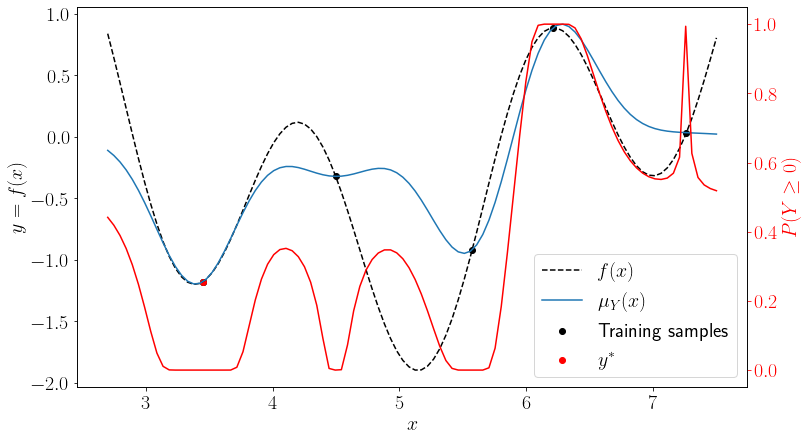

In [8]:
p_f = norm().cdf(y_pred_mu / y_pred_std)


fig, ax = plt.subplots(figsize=(12, 7))

ax.plot(x_grid, y_true, "--k", label="$f(x)$")
ax.plot(x_grid, y_pred_mu, label="$\mu_Y(x)$")
ax.scatter(x_train.ravel(), y_train.ravel(), label="Training samples", color="k")
ax.scatter(x_star, y_star, label="$y^*$", color="r")
ax2 = ax.twinx()
ax2.plot(x_grid, p_f, color="r")
ax.set_xlabel("$x$")
ax.set_ylabel("$y=f(x)$")
ax2.set_ylabel("$P(Y \geq 0)$")
ax2.yaxis.label.set_color("r")
ax2.tick_params(axis='y', colors='red')
_ = ax.legend()

It can be seen that the probability of feasibility $P(Y\leq0)$ is non-zero for unobserved portions of the optimization space even for some $\mu_Y(x) \leq 0$, whereas it is close to $1$ or $0$ near the observed samples.

Finally, let us plot $a_c(\cdot)$ for the following problem

\begin{align}
\mathrm{arg}\min_x \, & f(x)\\
\mathrm{s.t.} \, & f(x) \geq 0, i \in [1, n_c]
\end{align}



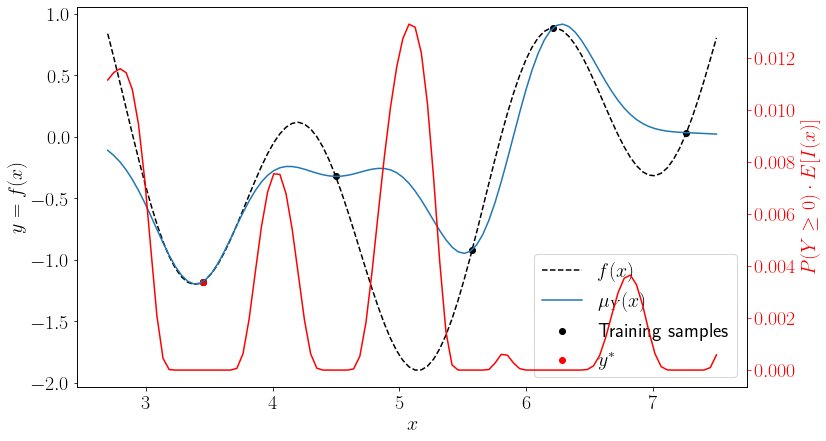

In [9]:
a_c = p_f * y_ei


fig, ax = plt.subplots(figsize=(12, 7))

ax.plot(x_grid, y_true, "--k", label="$f(x)$")
ax.plot(x_grid, y_pred_mu, label="$\mu_Y(x)$")
ax.scatter(x_train.ravel(), y_train.ravel(), label="Training samples", color="k")
ax.scatter(x_star, y_star, label="$y^*$", color="r")
ax2 = ax.twinx()
ax2.plot(x_grid, a_c, color="r")
ax.set_xlabel("$x$")
ax.set_ylabel("$y=f(x)$")
ax2.set_ylabel("$P(Y \geq 0) \cdot E[I(x)]$")
ax2.yaxis.label.set_color("r")
ax2.tick_params(axis='y', colors='red')
_ = ax.legend()